In [1]:
import numpy as np
import pylab as plt
from ant_array import RadioArray
from astropy.time import Time
import ephem
import h5py

import hickle as hkl
#import dask
#from dask.distributed import Client, progress
#client = Client(n_workers=7, threads_per_worker=1)

In [6]:
import cupy as cp

ModuleNotFoundError: No module named 'cupy'

In [2]:
filename_data = 'test-data/eda2/20200209/chan_204_20200209T034646_vis_real.fits'
filename_ant  = 'eda_antenna_locations_v2.h5'
# Setup array
f_mhz = np.array([159.3750])
lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500
t = Time('2020-02-09T03:46:46.0', format='isot')
sun = ephem.Sun()

# Initialize EDA array
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t.datetime, verbose=True, phase_center=sun)
eda.load_fits_data(filename_data)
#eda.date = t.datetime
#eda.update(t.datetime)

Time: 2020/2/9 03:46:46
Sun 	RA / DEC:  (21:29:01.23, -14:51:39.7) 
	ALT / AZ:  (74:49:40.3, 40:43:47.7)
ZENITH: (20:47:08.87, -26:46:33.5)
HA, D: (-0.18270382264997043, -14:51:39.7)
Applying phase delay matrix


In [3]:
wg = eda._generate_weight_grid(256)

/Users/dancpr/Data/eda_post_x/ant_array.py:346: RuntimeWarning: invalid value encountered in sqrt
  ng     = np.sqrt(1 - lg**2 - mg**2)


In [4]:
%timeit img2 = eda.make_image2(256)

943 ms ± 45.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit img = eda.make_image()

2.35 s ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
img = np.abs( eda.make_image2(256))

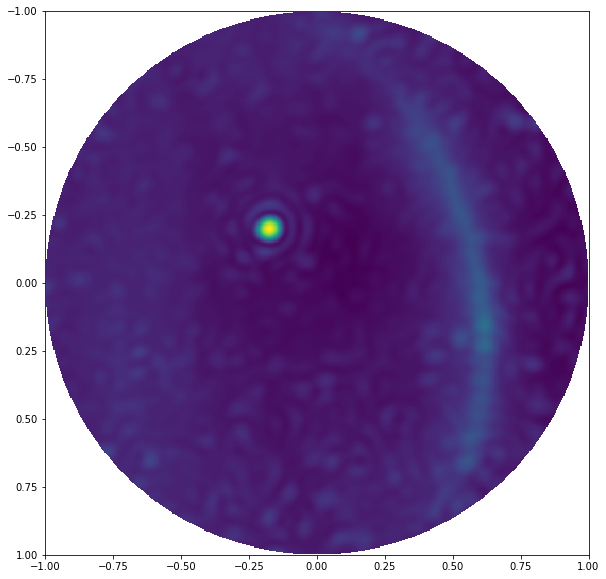

In [5]:
plt.figure(figsize=(10, 10))
eda.plot_imag(eda.make_image2(512))

/Users/dancpr/Data/blink/ant_array.py:345: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img), extent=(-1, 1, 1, -1), interpolation='none')
/Users/dancpr/Data/blink/ant_array.py:345: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img), extent=(-1, 1, 1, -1), interpolation='none')


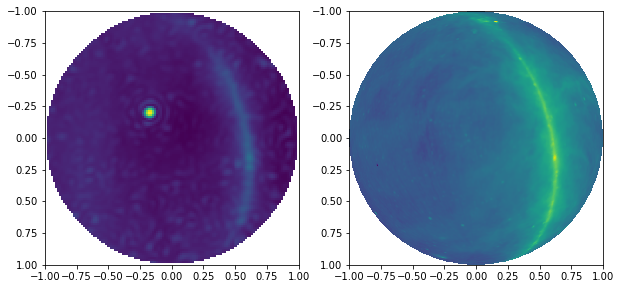

In [3]:
pmap = eda.generate_gsm()
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
eda.plot_image()

plt.subplot(1,2,2)
eda.plot_image(pmap)

In [103]:
sun.alt, sun.az

eda.point(np.pi/2 - sun.alt, sun.az)
eda.beamform()

#eda.point(np.pi/2, 0)
#eda.beamform()

(683341.1231301575+1.0186340659856796e-10j)

### HDF5 dataset

In [94]:
h5_path = '/Volumes/JIDIJIDI/astro-data/eda-post-x/corr_mat_chunked_2020.05.20.h5'
h5_metadata_path = '/Volumes/JIDIJIDI/astro-data/eda-post-x/corr_mat_metadata_v4_2020.05.20.h5'

md = h5py.File(h5_metadata_path, 'r')
f_mhz = md['freqs'][:]
t = Time(md['time'], format='jd')

sun = ephem.Sun()
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t[0].datetime, verbose=True, 
                 phase_center=sun, conjugate_data=True)
eda.load_h5_data(h5_path)

Time: 2020/5/20 03:43:36
Sun 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
HA, D: (-0.11820953279782864, 20:03:48.4)
Updating freq idx
Updating phase matrix
Time: 2020/5/20 03:43:36
Sun 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
HA, D: (-0.11820953279782864, 20:03:48.4)
conjugating data
Applying phase delay matrix


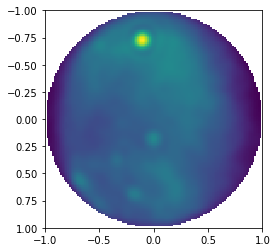

In [70]:
f_idx = 0
eda.verbose = False
eda.update(date=t[f_idx // 32].datetime, f_idx=f_idx, pol_idx=0)
eda.plot_image()

In [91]:
def run_imager(f_mhz, t, f_idxs):
    h5_path       = '/Volumes/JIDIJIDI/astro-data/corr_mat_chunked_2020.05.20.h5'
    filename_ant  = 'eda_antenna_locations_v2.h5'
    lat = '-26:42:11:95'
    lon = '116:40:14.93'
    elev = 500
    n_pix = 129
    sun = ephem.Sun()
    eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t[0].datetime, verbose=False, 
                     phase_center=sun, conjugate_data=True)
    eda.load_h5_data(h5_path)
    hkl.dump(f_idxs, f'dask-out/freqs-{f_idxs[0]}.hkl')
    for f_idx in f_idxs:
        for p_idx in (0,1,2,3):
            #print(f"generating F {f_idx} P {p_idx}")
            eda.update(date=t[f_idx // 32].datetime, f_idx=f_idx, pol_idx=p_idx)
            img = eda.make_image()
            hkl.dump(img, f'dask-out/img-f{f_idx}-p{p_idx}.hkl')
    return "ok"
            

In [6]:
n_f = 32 * 350
q_idxs = np.arange(n_f).reshape((350,32))

dqueue = []
for idxs in q_idxs:
    r = dask.delayed(run_imager)(f_mhz, t, idxs)
    dqueue.append(r)

In [7]:
q_r = dask.compute(*dqueue)

In [26]:
def make_image(self, n_pix=128):

    l = np.linspace(1, -1, n_pix)
    m = np.linspace(1, -1, n_pix)

    grid = np.zeros((n_pix, n_pix), dtype='float64')
    for xx in range(n_pix):
        for yy in range(n_pix):
            lm2 = l[xx]**2 + m[yy]**2
            if lm2 < 1:
                pvec = np.array((l[xx], m[yy], np.sqrt(1 - lm2)))
                self._point_vec(pvec)
                grid[yy, xx] = np.abs(self.beamform())
    return grid

n_pix = 128
l = np.linspace(1, -1, n_pix)
m = np.linspace(1, -1, n_pix)
grid = np.zeros((n_pix, n_pix), dtype='float64')
lg, mg = np.meshgrid(l, m)
lm2g = lg**2 + mg**2
sqrt_lm2g = np.sqrt(1 - lm2g)

from numba import njit, prange

def make_image2(self, n_pix=128):
    grid = np.zeros((n_pix, n_pix), dtype='float64')
    for xx in prange(n_pix):
        for yy in prange(n_pix):
            if sqrt_lm2g[xx, yy] < 1:
                pvec = np.array((lg[xx, yy], mg[xx,yy], sqrt_lm2g[xx, yy]))
                self._point_vec(pvec)
                grid[xx, yy] = np.abs(self.beamform())
    return grid

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_22004/2659554647.py:22: RuntimeWarning: invalid value encountered in sqrt
  sqrt_lm2g = np.sqrt(1 - lm2g)


### Extract pointings on fornax, pictor and the Sun

In [92]:
fn_cube = '/Volumes/JIDIJIDI/astro-data/eda-post-x/eda-channel-sweep-image-cube-fchunk.h5'

bw = 0.925926e6      # From header.txt
f0 = 7.8125E+07      # first uvfits file FREQ, in 100/merged/...uvfits
f1 = 7.890625E+07    # second uvfits file
fc_bw = bw/32        # Fine channel bandwidth
cc_sep = f1 - f0      # coarse channel separation (oversampling)
f = np.zeros(11200, dtype='float64')
x = np.arange(11200)
for ii in range(350):
    i0, i1 = ii*32, (ii+1)*32
    f[i0:i1] = f0 - x[16]* fc_bw + x[:32] * fc_bw + cc_sep * ii
assert f[16] == f0
assert f[16+32] == f1

with h5py.File(fn_cube, 'r') as h:
    md = {
        'freqs': f, 
        'ra': h['ra'][:],
        'dec': h['dec'][:], 
        'time': Time(h['time'][:], format='jd')
    }

In [108]:
h = h5py.File(fn_cube, 'r+')
h['freqs'] = f

OSError: Unable to open file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [35]:
from sky_model import make_source
from astropy.coordinates import SkyCoord

In [36]:
def generate_skycat(observer):

    skycat = {
        'Virgo_A': SkyCoord('12h 30m 49s', '+12:23:28', unit=('hourangle', 'degree')),
        'Hydra_A': SkyCoord('09h 18m 5.6s', '-12:5:44.0',  unit=('hourangle', 'degree')),
        'Centaurus_A':  SkyCoord('13h 25m 27.6s', '−43:01:09', unit=('hourangle', 'degree')),
        'Pictor_A': SkyCoord('05h 19m 49.721s', '−45:46:43.85', unit=('hourangle', 'degree')),
        'Hercules_A': SkyCoord('16h 51m 08.15', '+04:59:33.32', unit=('hourangle', 'degree')),
        'Fornax_A': SkyCoord('03h 22m 41.7', '−37:12:30', unit=('hourangle', 'degree')),

    }
    skycat.update(generate_skycat_solarsys(observer))
    return skycat

def generate_skycat_solarsys(observer):
    sun  = ephem.Sun()
    moon = ephem.Moon()
    sun.compute(observer)
    moon.compute(observer) 
    skycat = {
        'Sun': SkyCoord(sun.ra, sun.dec, unit=('rad', 'rad')),
        'Moon':  SkyCoord(moon.ra, moon.dec, unit=('rad', 'rad'))
    }
    return skycat

skycat = generate_skycat(eda)

In [98]:
srcs = {}
for name in ['Fornax_A', 'Pictor_A', 'Sun']:
    srcs[name] = make_source(name, skycat[name].ra.rad, skycat[name].dec.rad)

In [97]:
sun.compute(eda)
eda.point(np.pi/2 - sun.alt, sun.az)
b = eda.beamform().real
print(name, b)

Sun 46641.63618398398


In [99]:
for name, src in srcs.items():
    src.compute(eda)
    eda.point(np.pi/2 - src.alt, src.az)
    b = eda.beamform().real
    print(name, b)

Fornax_A 47826.93457598184
Pictor_A 48692.34322130696
Sun 47961.59448240853


In [100]:
m = eda.make_image()

In [101]:
np.max(m)

104528.96566217244

In [85]:
eda._src_hourangle(sun)

(-0.11820953279782864, 0.35017335867347105)

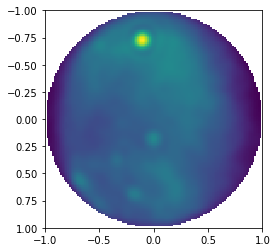

In [74]:
eda.plot_image()
sun.compute(eda)

In [76]:
eda.point(np.pi/2 - sun.alt, sun.az)
eda.beamform().real

46641.63618398398